## Predictive modeling of future customer demand trends

In [1]:
import pandas as pd
from pandas.plotting import autocorrelation_plot
from pandas import DataFrame
from pandas import concat
import numpy as np
from math import sqrt

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats import boxcox

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from matplotlib import colors
%matplotlib inline

In [2]:
df = '/Users/sseyeoni/Documents/jupyter/Cintas/Results/MBAinfo_Retail_Clean_update.xlsx'
df = pd.read_excel(df)

df.head()

,Material,Year/Period,Retail_sales
0,110,2020-04-01,183175
1,111,2020-04-01,243
2,112,2020-04-01,2096
3,113,2020-04-01,1673
4,120,2020-04-01,178781


In [3]:
jdf = '/Users/sseyeoni/Documents/jupyter/Cintas/Results/MARA_Clean.xlsx'
jdf = pd.read_excel(jdf)

jdf = jdf[['Material','Material Group']]
jdf.head()

,Material,Material Group
0,1,TRAINING
1,110,MISC_FA
2,112,MISC_FA
3,113,MISC_FA
4,120,MISC_FA


In [4]:
# perform left join on the 'Material' column
left_join = pd.merge(df, jdf, on='Material', how='left')
left_join.head()

,Material,Year/Period,Retail_sales,Material Group
0,110,2020-04-01,183175,MISC_FA
1,111,2020-04-01,243,NaN
2,112,2020-04-01,2096,MISC_FA
3,113,2020-04-01,1673,MISC_FA
4,120,2020-04-01,178781,MISC_FA


In [6]:
df = left_join
df = df.rename(columns={'Year/Period':'Date', 'Retail_sales':'Retail_Value'})

,Material,Date,Retail_Value,Material Group
72,5026,2020-04-01,4,TREATMENT
73,5048,2020-04-01,0,TREATMENT
82,10266,2020-04-01,1647,TREATMENT
83,10267,2020-04-01,0,TREATMENT
370,50009,2020-04-01,28308,TREATMENT


In [11]:
# extract the rows of each Material Group

TREATMENT = df[df['Material Group'] == 'TREATMENT']

TABLETS = df[df['Material Group'] == 'TABLETS']

BANDAGES = df[df['Material Group'] == 'BANDAGES']

HANDPROT = df[df['Material Group'] == 'HANDPROT']

EYEPROT = df[df['Material Group'] == 'EYEPROT']

DRESSING = df[df['Material Group'] == 'DRESSING']

EMERG_FA = df[df['Material Group'] == 'EMERG_FA']

INSTRUMNT = df[df['Material Group'] == 'INSTRUMNT']

SKINCARE = df[df['Material Group'] == 'SKINCARE']

In [8]:
# Each Material Group's retail value grouped by each date !!!!!!!!!!!!!
gdf = TREATMENT.groupby('Date')['Retail_Value'].sum()
gdf = gdf.reset_index()
gdf.head()

,Date,Retail_Value
0,2020-04-01,439714
1,2020-05-01,383508
2,2020-06-01,459030
3,2020-07-01,533776
4,2020-08-01,479677


In [9]:
gdf.Date = pd.to_datetime(gdf.Date)

gdf = gdf.set_index("Date")
gdf.head()

,Retail_Value
Date,
2020-04-01,439714
2020-05-01,383508
2020-06-01,459030
2020-07-01,533776
2020-08-01,479677


In [10]:
gdf.tail()

,Retail_Value
Date,
2022-11-01,550584
2022-12-01,553194
2023-01-01,596006
2023-02-01,553268
2023-03-01,623804


### Rolling Statistics

<AxesSubplot: xlabel='Date'>

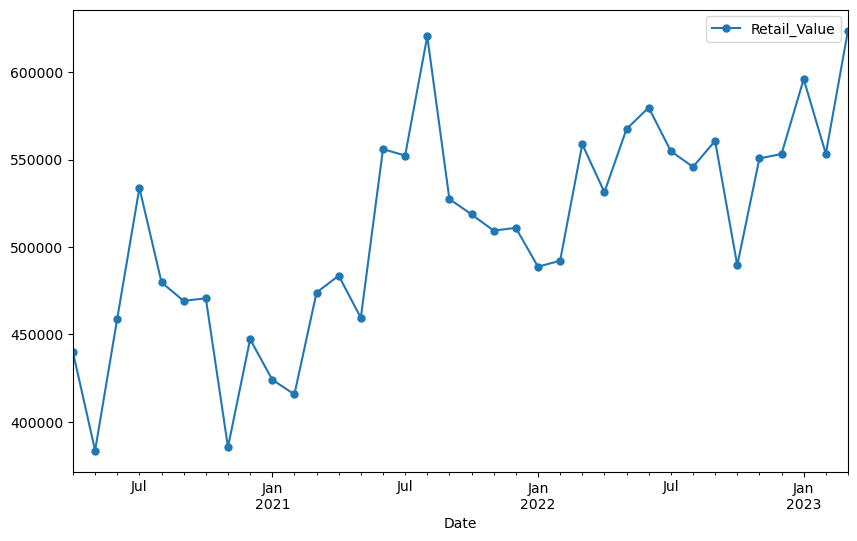

In [12]:
gdf['Retail_Value'].plot(figsize = (10,6), legend=True, marker='o', markersize=5)

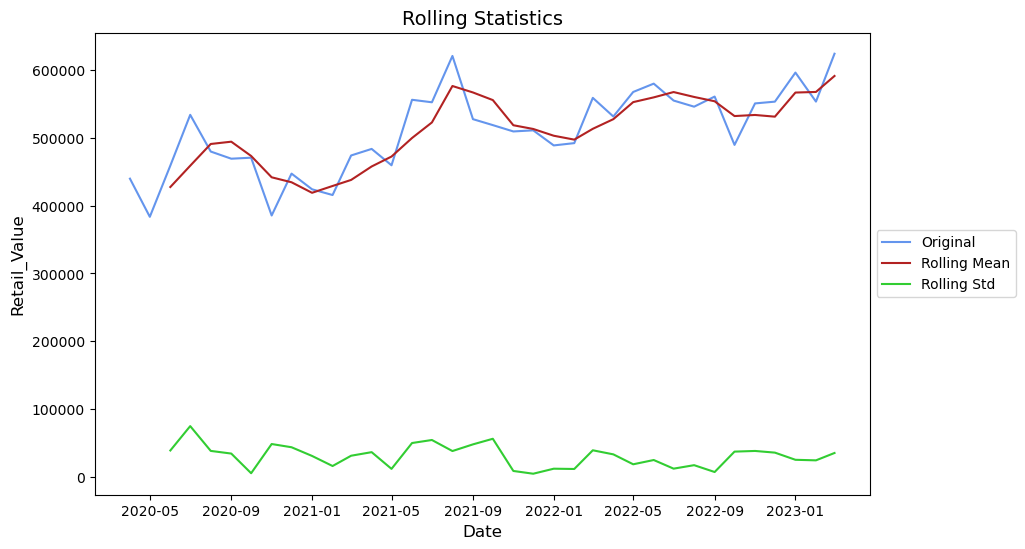

In [13]:
rolling_mean = gdf.rolling(window=3).mean()
rolling_std = gdf.rolling(window=3).std()

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(gdf, color='cornflowerblue', label='Original')
ax.plot(rolling_mean, color='firebrick', label='Rolling Mean')
ax.plot(rolling_std, color='limegreen', label='Rolling Std')

ax.set_xlabel('Date', size=12)
ax.set_ylabel('Retail_Value', size=12)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title('Rolling Statistics', size=14)

plt.show()

### Acf (Autocorrelation)

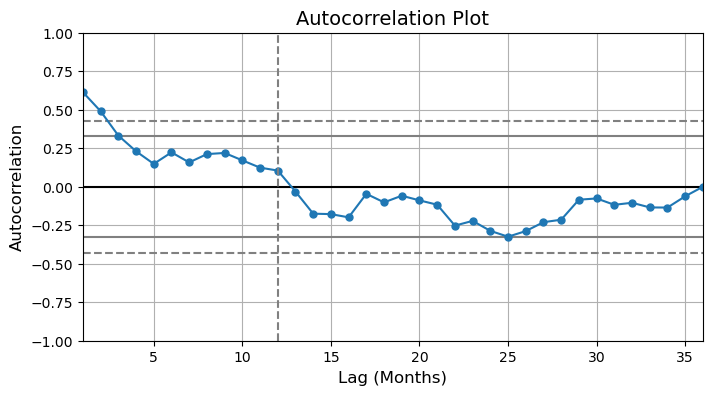

In [14]:
import matplotlib.pyplot as plt
from importlib import reload
plt=reload(plt)

plt.figure(figsize=(8, 4))
pd.plotting.autocorrelation_plot(gdf['Retail_Value'], marker='o', markersize=5)
plt.axvline(x=12, linestyle='--', color='grey')
plt.xlabel('Lag (Months)', fontsize=12)  # explicitly reference the xlabel function from matplotlib.pyplot
plt.ylabel('Autocorrelation', fontsize=12)
plt.title('Autocorrelation Plot', fontsize=14)
plt.show()

### Pacf (Partial Autocorrelation)

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


<Figure size 800x400 with 0 Axes>

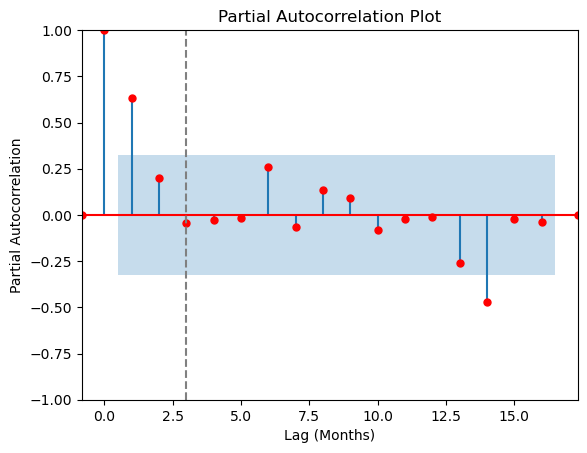

In [15]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt
from importlib import reload
plt=reload(plt)
# assume gdf is a pandas DataFrame containing the time series data

plt.figure(figsize=(8, 4))
plot_pacf(gdf['Retail_Value'], lags=16, marker='o', markersize=5, color='red')
plt.axvline(x=3, linestyle='--', color='grey')
plt.xlabel('Lag (Months)')
plt.ylabel('Partial Autocorrelation')
plt.title('Partial Autocorrelation Plot')
plt.show()

### Decomposition

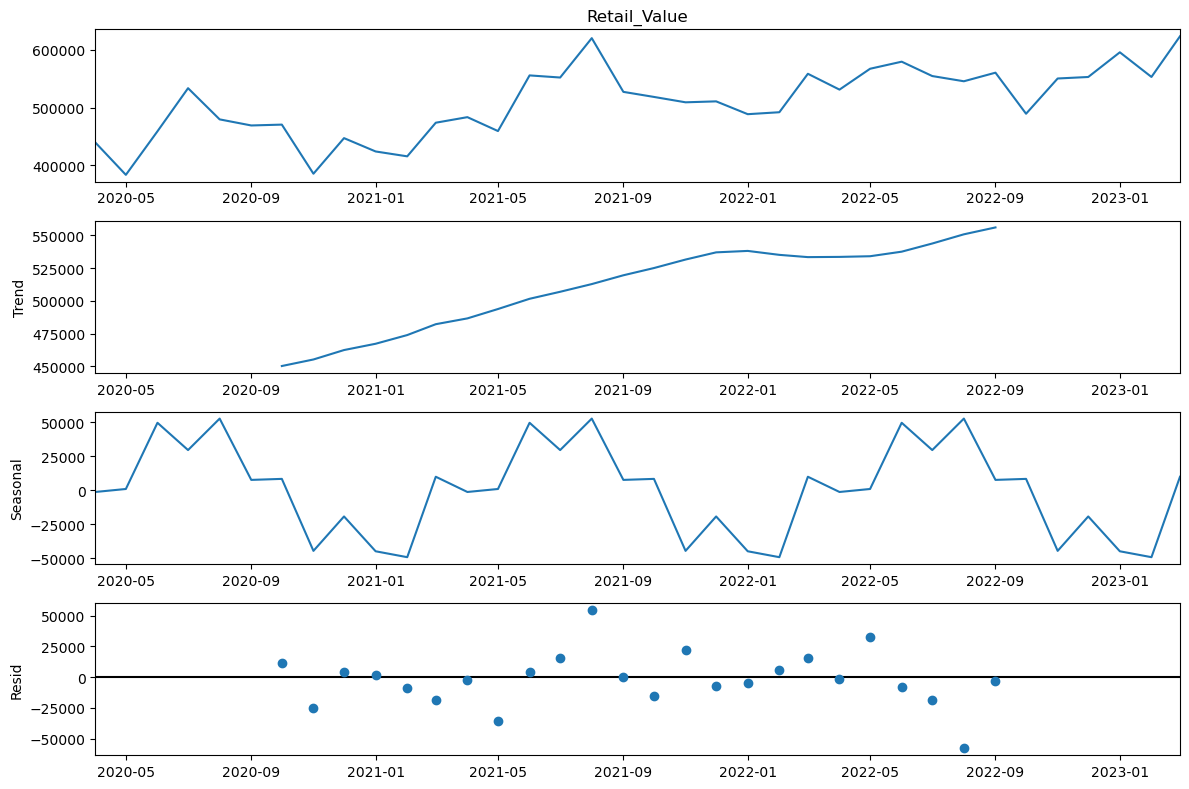

In [16]:
rcParams['figure.figsize'] = 12, 8
dec = seasonal_decompose(gdf["Retail_Value"], model = "add")
dec.plot();

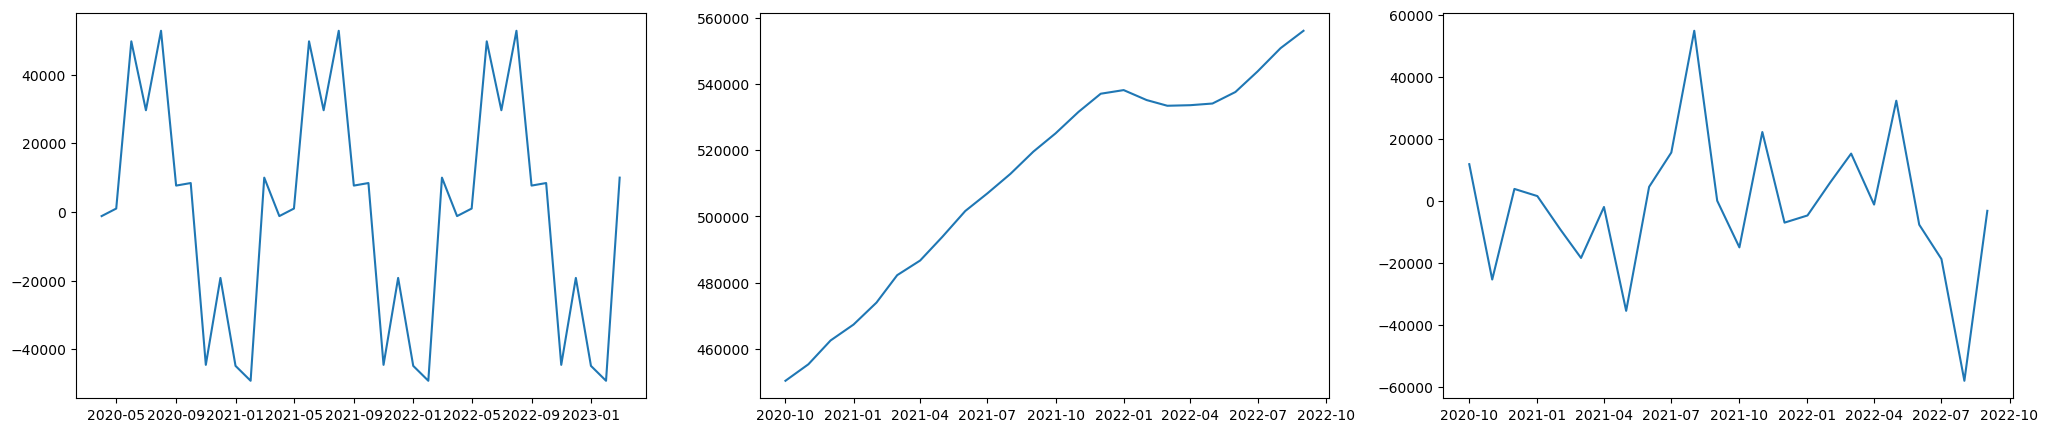

In [17]:
plt.figure(figsize = (25, 5))
a = seasonal_decompose(gdf["Retail_Value"], model = "add")
plt.subplot(1, 3, 1)
plt.plot(dec.seasonal)

plt.subplot(1, 3, 2)
plt.plot(dec.trend)

plt.subplot(1, 3, 3)
plt.plot(dec.resid)

plt.show()

In [18]:
# check for stationarity using the Augmented Dickey-Fuller test
result = adfuller(gdf['Retail_Value'])
print('ADF Statistic: {:.3f}'.format(result[0]))
print('p-value: {:.3f}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {:.3f}'.format(key, value))

ADF Statistic: -1.957
p-value: 0.306
Critical Values:
	1%: -3.639
	5%: -2.951
	10%: -2.614


## Forecasting Model

**ARIMA Model** stands for Auto-Regressive Integrated Moving Average.<br> It is is used for predicting future trends on a time series data. It is model that form of regression analysis.

**Auto-Regressive** models predict future behavior using past behavior where there is some correlation between past and future data.

**Integration** is the difference between present and previous observations. It is used to make the time series stationary.

**Moving Average** is a statistical method that takes the updated average of values to help cut down on noise. It takes the average over a specific interval of time

**p**: Value just before convergence in pacf. ( =3 )<br>
**d** : Check whether there is a trend by adf test and visual confirmation of the trend ( =0 )<br>
**q** : value just before convergence in acf ( =1)<br>
**P** : Check how many times the seasonality cycle was repeated in the pacf ( =0 )<br>
**D**: Check whether there is seasonality, 1 or 0 ( =0 ) depending on the need for seasonality difference <br>
**Q**: Check how many times the seasonal cycle based on acf has been repeated (=1)<br>
**m** : seasonal period ( =12 )

In [44]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

train_data = gdf[:len(gdf)-12]
test_data = gdf[len(gdf)-12:]

arima_model = SARIMAX(gdf['Retail_Value'], order = (2,0,5), seasonal_order = (3,0,2,12))
arima_result = arima_model.fit()
arima_result.summary()

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.48529D+02    |proj g|=  2.64940D+02

At iterate    5    f=  1.22752D+01    |proj g|=  1.57731D-01

At iterate   10    f=  1.21090D+01    |proj g|=  1.12551D-01

At iterate   15    f=  1.20503D+01    |proj g|=  2.61423D-02

At iterate   20    f=  1.20400D+01    |proj g|=  1.95014D-02

At iterate   25    f=  1.20289D+01    |proj g|=  2.82064D-02

At iterate   30    f=  1.20211D+01    |proj g|=  2.29085D-02

At iterate   35    f=  1.20157D+01    |proj g|=  2.41219D-02

At iterate   40    f=  1.20090D+01    |proj g|=  5.65544D-03

At iterate   45    f=  1.20087D+01    |proj g|=  1.44927D-03

At iterate   50    f=  1.20084D+01    |proj g|=  6.92876D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                            Retail_Value   No. Observations:                   36
Model:             SARIMAX(2, 0, 5)x(3, 0, [1, 2], 12)   Log Likelihood                -432.304
Date:                                 Wed, 26 Apr 2023   AIC                            890.607
Time:                                         20:57:05   BIC                            911.193
Sample:                                     04-01-2020   HQIC                           897.792
                                          - 03-01-2023                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2147      0.242      0.886      0.376      -0.260       0.690
ar.L2          0.7839      0.262      2.990      0.003       0.270       1.298
ma.L1          0.2857      0.306      0.934      0.350      -0.314       0.885
ma.L2         -0.2289      0.315     -0.727      0.467      -0.846       0.389
ma.L3          0.1906      0.282      0.676      0.499      -0.362       0.743
ma.L4         -0.1068      0.300     -0.356      0.722      -0.695       0.482
ma.L5         -0.5293      0.264     -2.008      0.045      -1.046      -0.013
ar.S.L12      -0.4950    820.133     -0.001      1.000   -1607.926    1606.937
ar.S.L24      -0.3458    462.313     -0.001      0.999    -906.462     905.771
ar.S.L36       0.1412    248.378      0.001      1.000    -486.671     486.953
ma.S.L12       1.2697    893.208      0.001      0.999   -1749.386    1751.926
ma.S.L24       0.7725     52.497      0.015      0.988    -102.120     103.665
sigma2       9.61e+08   3.45e-06   2.78e+14      0.000    9.61e+08    9.61e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.91   Jarque-Bera (JB):                 0.61
Prob(Q):                              0.34   Prob(JB):                         0.74
Heteroskedasticity (H):               0.44   Skew:                             0.28
Prob(H) (two-sided):                  0.16   Kurtosis:                         2.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.68e+33. Standard errors may be unstable.
"""

In [45]:
arima_pred = arima_result.predict(start = len(train_data), end = len(gdf)-1, typ="levels").rename("ARIMA Predictions")
arima_pred

2022-04-01    534884.615283
2022-05-01    531696.284415
2022-06-01    587423.742674
2022-07-01    577922.292951
2022-08-01    590173.878233
2022-09-01    535895.309760
2022-10-01    496705.413325
2022-11-01    553496.966903
2022-12-01    521837.834739
2023-01-01    562423.968079
2023-02-01    544369.147552
2023-03-01    614130.485178
Freq: MS, Name: ARIMA Predictions, dtype: float64

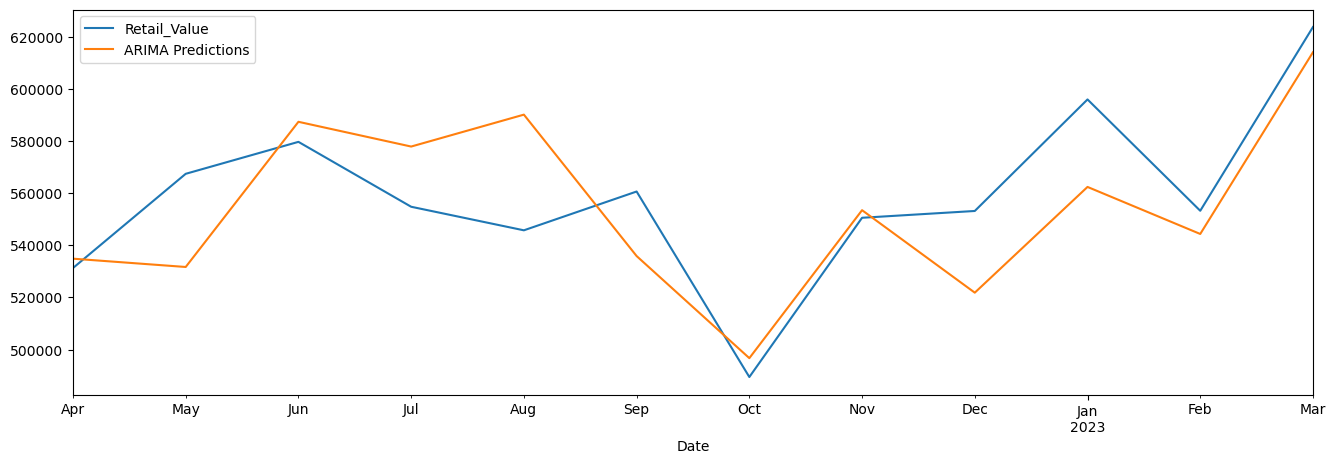

In [46]:
test_data['Retail_Value'].plot(figsize = (16,5), legend=True)
arima_pred.plot(legend = True);

In [47]:
from statsmodels.tools.eval_measures import rmse

arima_rmse_error = rmse(test_data['Retail_Value'], arima_pred)
arima_mse_error = arima_rmse_error**2
mean_value = gdf['Retail_Value'].mean()

print(f'MSE Error: {arima_mse_error}\nRMSE Error: {arima_rmse_error}\nMean: {mean_value}')

MSE Error: 567902053.5549945
RMSE Error: 23830.695616263376
Mean: 510141.97222222225


In [48]:
arima_pred_f = arima_result.predict(start = len(gdf), end = len(gdf)+12, typ="levels").rename("ARIMA Predictions")
arima_pred_f

2023-04-01    576234.516649
2023-05-01    599207.959029
2023-06-01    563446.963483
2023-07-01    574572.055592
2023-08-01    509838.598366
2023-09-01    570978.533272
2023-10-01    519245.246830
2023-11-01    548829.668930
2023-12-01    562209.914191
2024-01-01    598199.873907
2024-02-01    565816.040092
2024-03-01    597079.031766
2024-04-01    577708.389040
Freq: MS, Name: ARIMA Predictions, dtype: float64

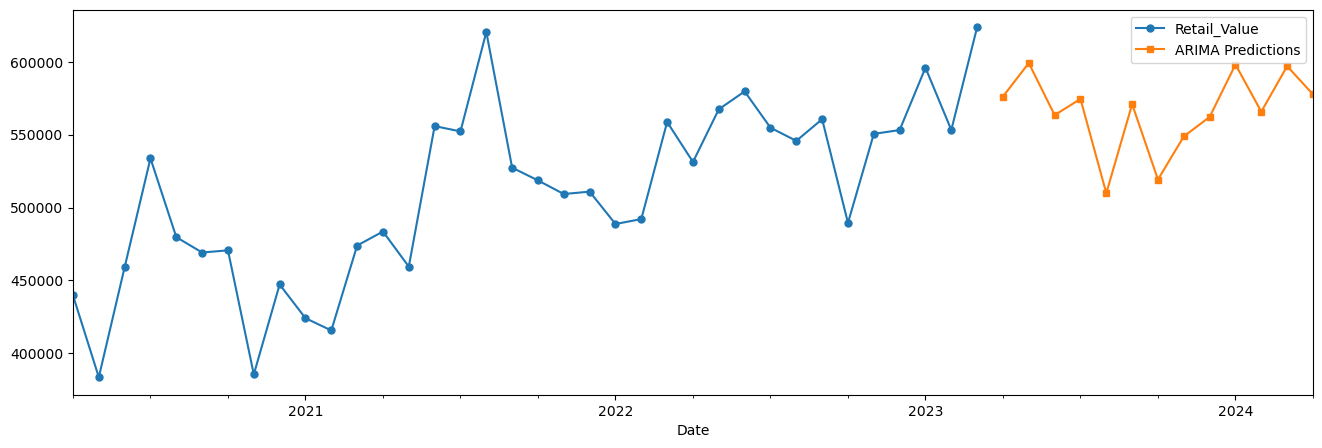

In [49]:
gdf['Retail_Value'].plot(figsize = (16,5), legend=True, marker='o', markersize=5)
arima_pred_f.plot(legend = True, marker='s', markersize=5);

In [50]:
pdf = arima_pred_f.to_frame(name='Retail_Value')
pdf.head()

,Retail_Value
2023-04-01,576234.516649
2023-05-01,599207.959029
2023-06-01,563446.963483
2023-07-01,574572.055592
2023-08-01,509838.598366


In [51]:
udf = pd.concat([gdf, pdf])

udf.reset_index(inplace=True)
udf = udf.rename(columns = {'index':'Date'})

In [52]:
udf.head()

,Date,Retail_Value
0,2020-04-01,439714.0
1,2020-05-01,383508.0
2,2020-06-01,459030.0
3,2020-07-01,533776.0
4,2020-08-01,479677.0


In [53]:
udf.to_csv('/Users/sseyeoni/Documents/jupyter/Cintas/Forecasting/Results/Retail_Predictive_Model_TREATMENT.csv', index=False)